In [1]:
from __future__ import division, print_function
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import make_interp_spline
from scipy import stats
from scipy import optimize
from sklearn.decomposition import PCA
from scipy.integrate import quad
from matplotlib.pyplot import cm
from numpy.polynomial import polynomial
import hashlib
import os
import glob
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14
import matplotlib.pyplot as plt

In [2]:
def msu(coseta, p1=0.3, p2=0):
    '''
    MSU parameterization 
    https://wiki.icecube.wisc.edu/index.php/MSU_Forward_Hole_Ice
    '''
    f = lambda x : (1 + 1.5 * x - x**3/2.) + p1 * x * (x**2 -1)**3 +p2 * np.exp(10*(x-1.2))
    norm = quad(f, -1, 1)
    return f(coseta) * 0.68 / norm[0]

# Load some angular acceptance models

In [3]:
xnew = np.linspace(-1,1,101)

models = {}
files = [f for f in glob.glob('/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.*')]
for file in files:
    print(file)
    with open(file, 'r') as m:
        poly = m.readlines()
        poly = [float(c.strip()) for c in poly]
        f = polynomial.Polynomial(poly[1:])
        models[file.split('.')[-1]] = f(xnew)
        
# from Martin R.
f = polynomial.Polynomial([ 2.06777114e-14,  1.74719461e-14, -5.67238286e-14, -3.42800409e-14,  4.95514301e-14, -7.42966323e-02, -5.41036322e-03, -9.07768380e-02, -8.56063000e-02, 4.30334072e-01,  3.55900800e-01][::-1])
norm = quad(f, -1, 1)
models['martin_0.6_14'] = f(xnew) * 0.68 / norm[0]
f = polynomial.Polynomial([ 3.36087298e-14,  1.36499579e-14, -7.97723716e-14, -2.26422656e-14,  6.30906222e-14, -2.46424084e-01, -2.53383207e-01, -4.97533265e-02,  8.79281247e-02,  4.82721282e-01,  3.52484462e-01][::-1])
norm = quad(f, -1, 1)
models['martin_0.8_40'] = f(xnew) * 0.68 / norm[0]
f = polynomial.Polynomial([-2.32400791e-14,  1.17692970e-14,  4.23202843e-14, -2.87362984e-14, -2.51280360e-14, -5.00046160e-01, -6.38566738e-01,  7.87329961e-02,  3.45636471e-01,  4.76239349e-01,  3.51226068e-01][::-1])
norm = quad(f, -1, 1)
models['martin_1.8_125'] = f(xnew) * 0.68 / norm[0]

models['greco'] = msu(xnew, p1=(0.3+0.49*0.1), p2=-0.63)
models['dragon'] = msu(xnew, p1=(0.3-0.25*0.1), p2=-1.15)
models['baseline'] = msu(xnew, p1=(0.3), p2=-1)
models['msu2'] = msu(xnew, p1=(0.3), p2=1)
models['dima'] = msu(xnew, p1=(0.3), p2=0)
models['dima+'] = msu(xnew, p1=(0.4), p2=0)
models['dima-'] = msu(xnew, p1=(0.2), p2=0)

/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.30_p2_-1
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.25_p2_-2
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.h3-30cm
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.20_p2_0
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.30_p2_-3
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.35_p2_0
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.25_p2_+2
/cvmfs/icecube.opensciencegri

In [4]:
#models = {k: models[k] for k in ['h1-100cm', 'h2-50cm', 'h3-30cm', 'nominal', '30_p2_0', '25_p2_0', '35_p2_0', 'dragon', 'greco', 'baseline', '30_p2_+1']}
models = {k: models[k] for k in ['h1-100cm', 'h2-50cm', 'h3-30cm', 'nominal', 'dima', 'dima+', 'dima-', 'dragon', 'greco', 'baseline', 'msu2', 'martin_0.6_14', 'martin_0.8_40', 'martin_1.8_125']}
#models = {k: models[k] for k in ['nominal', 'dima', 'dima+', 'dima-', 'dragon', 'greco', 'baseline', 'msu2', 'martin_0.6_14', 'martin_0.8_40', 'martin_1.8_125']}

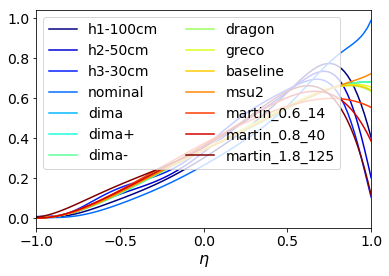

In [5]:
colors = cm.jet(np.linspace(0,1,len(models)))

for target, name, color in zip(models.values(), models.keys(), colors):
    plt.plot(xnew, target, label=name, c=color)

plt.gca().set_xlim([-1,1])
plt.gca().set_xlabel(r'$\eta$')
plt.gca().legend(loc='upper left', ncol=2)
plt.savefig('all.png')

# Approximate those by splines

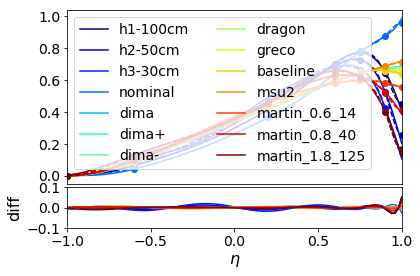

In [6]:
#support_x = np.array([-1., -0.6, -0.25,  0.1, 0.25, 0.4,  0.6, 0.75, 0.9, 1.])
support_x = np.array([-1., -0.6,  0.2, 0.6, 0.75, 0.9, 1.])
#support_x = np.array([-1.  , -0.6 , -0.25,  0.1 ,  0.5 ,  0.9 ,  1.  ])
initial_y = np.ones_like(support_x) * 0.5

# this sets the derivative=0 boundary conditions
bc_type=([(1, 0.0)], [(1, 0.0)])
#bc_type=None

def fun(y, support_x, target):
    '''
    Minimizer objective
    '''
    # we fix the leftmost point to 0
    y[0] = 0
    cubic = make_interp_spline(support_x, y, bc_type=bc_type)
    diff = target - cubic(xnew)
    return np.sqrt(np.sum(np.square(diff)))

fig = plt.figure()
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=8, fig=fig)
ax2 = plt.subplot2grid((10,1), (8,0),sharex=ax1,rowspan=2, fig=fig)

y_points = []

for target, name, color in zip(models.values(), models.keys(), colors):
    opt = optimize.minimize(fun, x0=initial_y, method='L-BFGS-B', args=(support_x, target))
    y = opt['x']
    y_points.append(y)

    cubic = make_interp_spline(support_x, y, bc_type=bc_type)
    ax1.plot(support_x, y, 'o', c=color)
    ax1.plot(xnew, cubic(xnew), '--', c=color)
    ax1.plot(xnew, target, label=name, c=color)
    ax2.plot(xnew, cubic(xnew) - target, c=color)

y_points = np.stack(y_points)

ax1.set_xlim([-1,1])
ax2.set_xlim([-1,1])
ax1.get_xaxis().set_visible(False)

ax2.set_ylim([-0.1, 0.1])
ax2.hlines(0,-1,1)
ax2.set_ylabel('diff')
ax2.set_xlabel(r'$\eta$')

ax1.legend(loc='best', ncol=2)
plt.show()
fig.savefig('approx.png')

# Reduce dimensionality
by doing a PCA decomposition and taking the two most important components

In [7]:
n_components=2

transformer = PCA(n_components=n_components, random_state=0)
out = transformer.fit_transform(y_points)

print(transformer.explained_variance_)
print(transformer.singular_values_)

[0.06935327 0.00540901]
[0.94952226 0.26517372]


2.3790493384824782e-17 3.9405683730713505
1.9329775875170135e-17 14.110211786944085


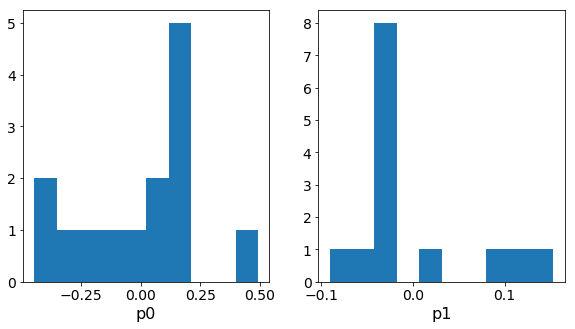

In [8]:
# let's investigate the interesting parameter ranges

fig = plt.figure(figsize=(15,5))
for i in range(out.shape[1]):
    ax = plt.subplot2grid((1,out.shape[1]+1), (0,i), rowspan=1, fig=fig)
    ax.hist(out[:,i])
    ax.set_xlabel('p%i'%i)
    print(np.mean(out[:,i]), 1./ np.std(out[:,i]))
plt.savefig('dist.png')

In [9]:
# now then build a function with 2 parameters

def ang(params, values):
    '''
    New angular acceptance funcion
    
    params : list / array
        the two parametrrs p1 and p2
    values : array
        the eta values to compute the angular acceptance for in (-1, 1)
    '''
    transformed_params = transformer.inverse_transform(params)
    f = make_interp_spline(support_x, transformed_params, bc_type=bc_type)
    positive_f = lambda x : np.clip(f(x), 0., None)
    
    norm = quad(positive_f, -1, 1)
    out = positive_f(values)
    #normalize....why 0.68?
    out /= norm[0] / 0.68
    
    return out

# Samples & Envelope
let's do some random sampling of the new function

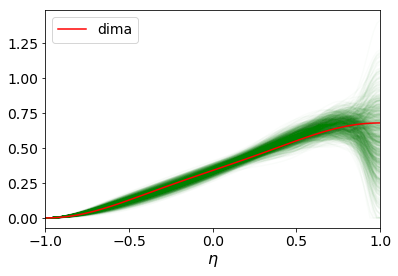

In [10]:
n = 1000

all_curves = np.ones(shape=(n, xnew.shape[0]))

for i in range(n):
    params = []
    for j in range(out.shape[1]):
        r = np.random.randn(1)
        params.append(r[0] * np.std(out[:,j]))
    all_curves[i] = ang(params, xnew)
    plt.plot(xnew, all_curves[i], c='green', alpha=20./n)
    #plt.plot(xnew, cubic(xnew), c='green', alpha=20./n)
                
plt.gca().set_xlim([-1,1])    
#plt.plot(xnew, msu(xnew, p1=0.2, p2=0), c='k')
plt.plot(xnew, models['dima'], c='r', label='dima')
#plt.plot(xnew, msu(xnew, p1=0.4, p2=0), c='k')
plt.legend()
plt.gca().set_xlabel(r'$\eta$')
plt.savefig('rand.png')

In [11]:
p16 = np.percentile(all_curves, 16, axis=0)
p84 = np.percentile(all_curves, 86, axis=0)
p25 = np.percentile(all_curves, 2.5, axis=0)
p975 = np.percentile(all_curves, 97.5, axis=0)
p50 = np.percentile(all_curves, 50, axis=0)

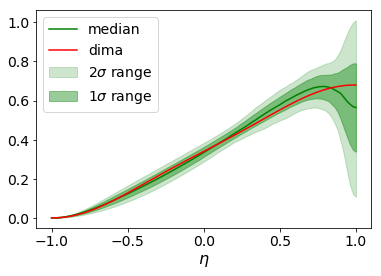

In [12]:
plt.fill_between(xnew, p25, p975, alpha=0.2, color='green', label=r'2$\sigma$ range')
plt.fill_between(xnew, p16, p84, alpha=0.4, color='green', label=r'1$\sigma$ range')
plt.plot(xnew, p50, color='g', label='median')
plt.plot(xnew, models['dima'], c='r', label='dima')
plt.gca().set_xlabel(r'$\eta$')
plt.legend(loc='upper left')
plt.savefig('envelope.png')

# Fit back to original models
How good does it approximate the original functions?

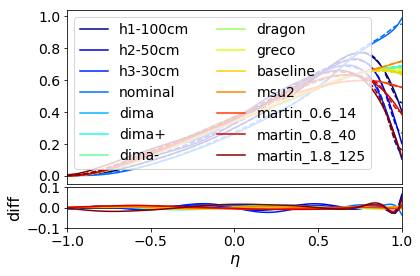

In [13]:
def fun(params, target):
    diff = ang(params, xnew) - target
    return np.sqrt(np.sum(np.square(diff)))

fig = plt.figure()
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=8, fig=fig)
ax2 = plt.subplot2grid((10,1), (8,0),sharex=ax1,rowspan=2, fig=fig)

new_params = {}

for target, name, color in zip(models.values(), models.keys(), colors):
    
    opt = optimize.minimize(fun, x0=np.zeros(out.shape[1]), method='BFGS', args=(target)) 
    new_params[name] = opt['x']

    new = ang(opt['x'], xnew)
    ax1.plot(xnew, new, '--', c=color)
    ax1.plot(xnew, target, label=name, c=color)
    ax2.plot(xnew, new - target, c=color)


ax1.set_xlim([-1,1])
ax2.set_xlim([-1,1])
ax1.get_xaxis().set_visible(False)

ax2.set_ylim([-0.1, 0.1])
ax2.hlines(0,-1,1)
ax2.set_ylabel('diff')
ax2.set_xlabel(r'$\eta$')

ax1.legend(loc='upper left', ncol=2)
plt.show()
fig.savefig('approx_new.png')

# morph from one to another model
Let's have some fun by morphing from dima to H2 in a couple intermediate steps

/home/peller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


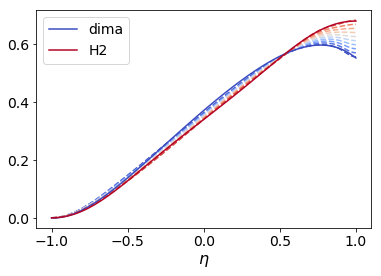

In [14]:
n = 10.

m1 = 'martin_0.6_14'
m2 = 'dima'

param_space = np.zeros((int(n), n_components))

for i in range(n_components):
    param_space[:,i] = np.linspace(new_params[m1][i], new_params[m2][i], n, endpoint=True)

cmap = cm.coolwarm

for i in range(int(n)):
    plt.plot(xnew, ang(param_space[i], xnew), c=cmap(i/n), ls='--')
    
plt.plot(xnew, models[m1], color=cmap(0.), label='dima')
plt.plot(xnew, models[m2], color=cmap(1.), label='H2')
plt.legend()
plt.gca().set_xlabel(r'$\eta$')

plt.savefig('morph.png')

In [15]:
import pandas as pd
df = pd.DataFrame(new_params)
df = df.transpose()
df.columns = ['p0', 'p1']
df

,p0,p1
h1-100cm,-0.073760,0.145336
h2-50cm,-0.298816,0.094008
h3-30cm,-0.451845,0.028703
nominal,0.481789,0.131591
dima,0.147192,-0.035671
dima+,0.152166,-0.044044
dima-,0.142221,-0.027304
dragon,0.104971,-0.031374
greco,0.127269,-0.038596
baseline,0.111601,-0.033770


# make it into a small python module

In [16]:
module_src = '''from __future__ import division, print_function
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import make_interp_spline
from numpy.polynomial import polynomial

# these values are obtained from a fit (explained in https://github.com/philippeller/angular_acceptance/blob/master/Angular_acceptance.ipynb)
'''
module_src += 'support_x = np.%s'%repr(support_x)
module_src += '\ncomponents = np.%s'%repr(transformer.components_)
module_src += '\nmean = np.%s'%repr(transformer.mean_)
module_src += '\nn_components = %s'%n_components
module_src += '''

def ang(params, values):
    """
    New angular acceptance function
    
    params : list / array
        the parameters p0, p1, ...
    values : float, list, array
        the eta values to compute the angular acceptance for in (-1, 1)
    """
    # sanity check
    assert np.all(np.logical_and(np.greater_equal(values, -1), np.less_equal(values, 1))), 'values must be in range -1, 1'
    p = np.zeros(n_components)
    p[:len(params)] = params
    # inverse PCA transform
    transformed_params = np.dot(p, components) + mean
    # construct spline
    f = make_interp_spline(support_x, transformed_params, bc_type=([(1, 0.)], [(1, 0.)]))
    # make sure we're positive everywhere
    positive_f = lambda x : np.clip(f(x), 0., None)
    # normalize
    norm = quad(positive_f, -1, 1)
    out = positive_f(values)
    #normalize....why 0.68?
    out *= 0.68 / norm[0]
    return out
    
def angsens_poly(params):
    """
    Return standard IceCube format
    
    params : list/array
        the parameters p0, p1, ... 
    """
    
    x = np.linspace(-1,1,101)
    sampled = ang(params, x)
    coeffs = np.zeros(12)
    coeffs[0] = np.max(sampled)
    coeffs[1:] = polynomial.polyfit(x, sampled, 10)
    return coeffs
    
if __name__=='__main__':
    from sys import argv
    params = [0.]*n_components
    if len(argv) > 0:
        params[:len(argv)-1] = [float(a) for a in argv[1:]]
    print('\\n'.join([str(a) for a in angsens_poly(params)]))
'''

h = hashlib.md5(module_src.encode('utf8'))
module_src = '# version %s\n'%h.hexdigest() + module_src

with open('unified_angular_acceptance.py', 'w') as f:
    f.write(module_src)

In [17]:

with open('/cvmfs/icecube.opensciencegrid.org/py2-v3/Ubuntu_16.04_x86_64/metaprojects/simulation/V06-00-02-RC2/ice-models/resources/models/angsens_flasher/as.8', 'r') as m:
    poly = m.readlines()
    poly = [float(c.strip()) for c in poly]

f = polynomial.Polynomial(poly[1:])

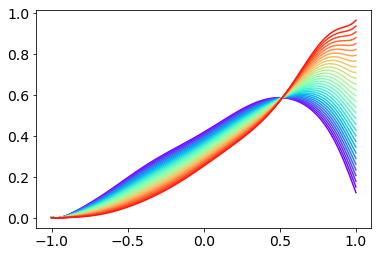

In [18]:
from unified_angular_acceptance import angsens_poly
from numpy.polynomial import polynomial
N = 31
eta = np.linspace(-1,1,101)
for i, p in enumerate(zip(np.linspace(-0.5,0.5,N), np.linspace(-0.2,0.2,N))):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), c=cm.rainbow(i/N))

In [19]:
print(df)

                      p0        p1
h1-100cm       -0.073760  0.145336
h2-50cm        -0.298816  0.094008
h3-30cm        -0.451845  0.028703
nominal         0.481789  0.131591
dima            0.147192 -0.035671
dima+           0.152166 -0.044044
dima-           0.142221 -0.027304
dragon          0.104971 -0.031374
greco           0.127269 -0.038596
baseline        0.111601 -0.033770
msu2            0.182308 -0.037547
martin_0.6_14  -0.007031 -0.088499
martin_0.8_40  -0.177663 -0.040039
martin_1.8_125 -0.443598 -0.031291


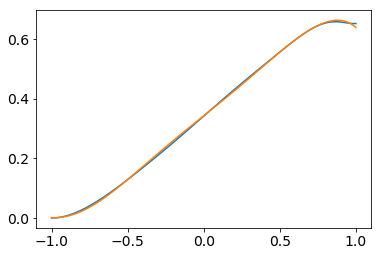

In [20]:
coef = angsens_poly(new_params['baseline'])
newf = polynomial.Polynomial(coef[1:])
plt.plot(eta, newf(eta))
plt.plot(eta, models['baseline'])
